In [12]:
import pandas as pd
from pathlib import Path

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from statsmodels.tsa import arima_process

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.rcParams['figure.figsize'] = (15, 6)  # overwrite the default figure size
plt.rcParams['axes.grid'] = True          # add the grid lines by default 

In [7]:
root = Path().absolute().parent
fp = root / 'data'/'week2'/'sealevel.csv'
df = pd.read_csv(fp, parse_dates=[['year', 'month']], index_col=0)

df.head(3)

,sealevel
year_month,
1995-01-01,0.0
1995-02-01,2.1
1995-03-01,1.8


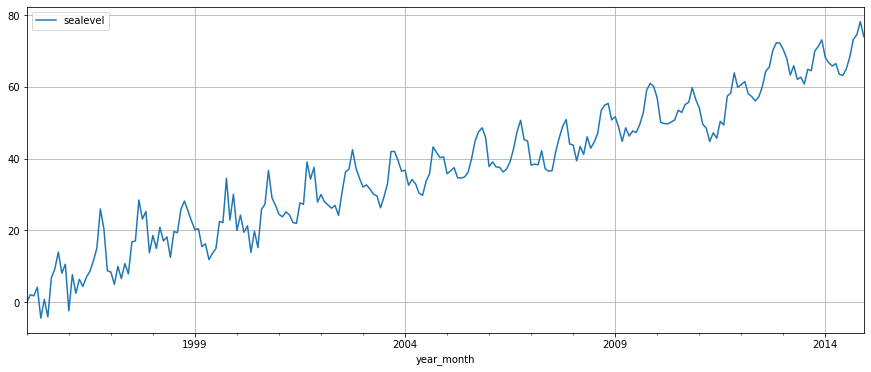

In [8]:
df.plot()

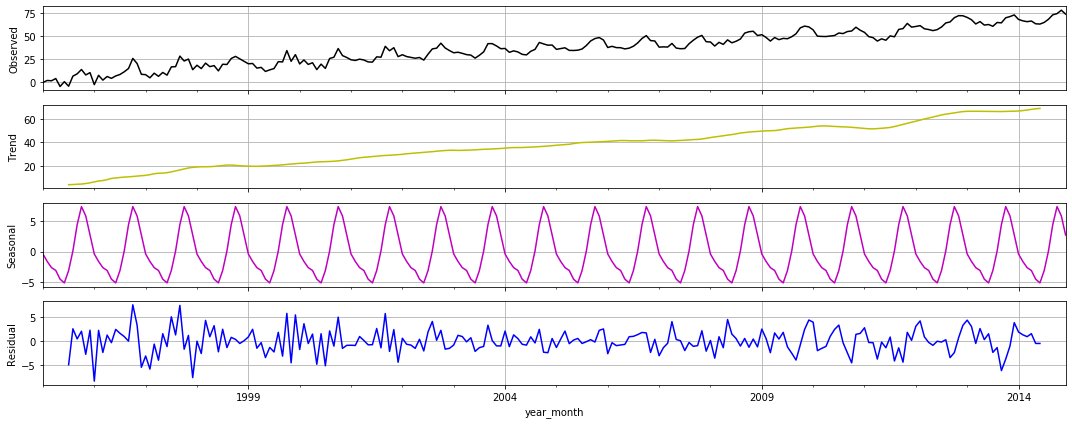

In [13]:
def plot_colored_seasonal_decompose(timeseries, colors=('k', 'y', 'm', 'b'), **kwargs):
    fig = seasonal_decompose(timeseries, **kwargs).plot()
    for ax, line_color in zip(fig.axes, colors):
        ax.get_lines()[0].set_color(line_color)
    return fig

plot_colored_seasonal_decompose(df, freq=12);

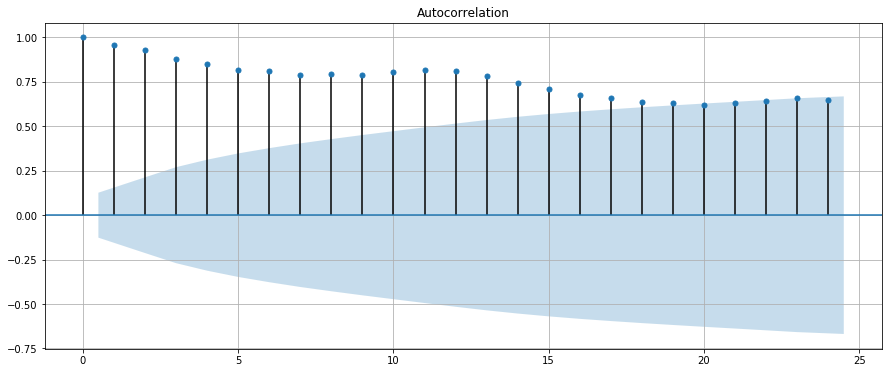

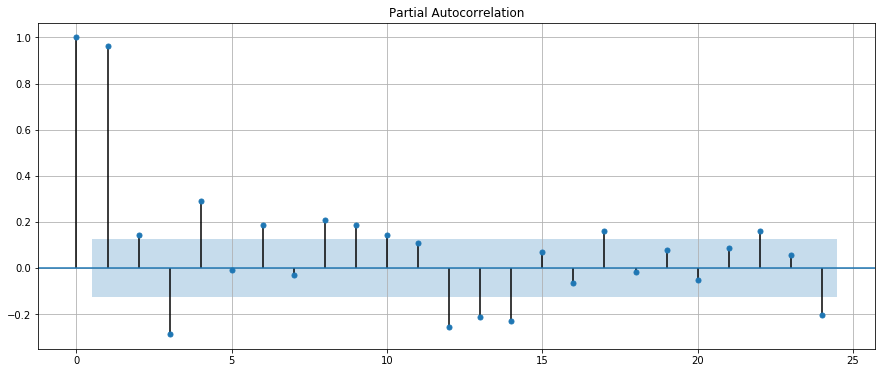

In [16]:
tsaplots.plot_acf(df)
tsaplots.plot_pacf(df);

In [ ]:
from statsmodels.tsa import arima_process